In [1]:
%pip install git+https://github.com/ytdl-org/youtube-dl

  Cloning https://github.com/ytdl-org/youtube-dl to /private/var/folders/8v/d886z5j13dsctyjpw29t7y480000gn/T/pip-req-build-ljze0xi6
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl /private/var/folders/8v/d886z5j13dsctyjpw29t7y480000gn/T/pip-req-build-ljze0xi6


  Resolved https://github.com/ytdl-org/youtube-dl to commit a08f2b7e4567cdc50c0614ee0a4ffdff49b8b6e6


  Preparing metadata (setup.py) ... -

 done


Note: you may need to restart the kernel to use updated packages.


In [2]:
%%bash
# check the right python is being used (same as kernel python)
which python
which youtube-dl
mkdir -p sample_videos
cd sample_videos
which youtube-dl
youtube-dl 'https://www.youtube.com/watch?v=YwWtDSponlc&ab_channel=CNBCTelevision'
youtube-dl 'https://www.youtube.com/watch?v=L9Tyb_ycRfU&ab_channel=CNBCTelevision'
youtube-dl 'https://www.youtube.com/watch?v=0wJqgHSfYi0&ab_channel=CNBCTelevision'

/Users/orm/mambaforge/envs/pixeltable_39/bin/python


/Users/orm/mambaforge/envs/pixeltable_39/bin/youtube-dl


/Users/orm/mambaforge/envs/pixeltable_39/bin/youtube-dl


[youtube] YwWtDSponlc: Downloading webpage


[download] Right now you want to be invested in companies that don't cater to the consumer, says Jim Cramer-YwWtDSponlc.mp4 has already been downloaded and merged


[youtube] L9Tyb_ycRfU: Downloading webpage


[download] Jim Cramer looks at how the Fed minutes spooked the markets today-L9Tyb_ycRfU.mp4 has already been downloaded and merged


[youtube] 0wJqgHSfYi0: Downloading webpage


[download] Snowflake CEO joins Jim Cramer after earnings report drives stock higher-0wJqgHSfYi0.mp4 has already been downloaded and merged


In [3]:
import pathlib
import pixeltable as pxt

In [4]:
pxt.create_dir('transcription_demo', ignore_errors=True)

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/orm/.pixeltable/pgdata


In [5]:
pxt.drop_table('transcription_demo.sentence_view', ignore_errors=True)
pxt.drop_table('transcription_demo.video_table', ignore_errors=True)
video_table = pxt.create_table('transcription_demo.video_table', {'video': pxt.VideoType()},)

Created table `video_table`.


In [6]:
paths = [str(pathlib.Path(p).absolute()) for p in pathlib.Path('./sample_videos/').iterdir()]
video_table.insert([{'video': video_path} for video_path in paths[:2] ])

Inserting rows into `video_table`: 0 rows [00:00, ? rows/s]

Inserting rows into `video_table`: 2 rows [00:00, 1672.70 rows/s]


Inserted 2 rows with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [7]:
from pixeltable.functions.video import get_metadata, extract_audio
from pixeltable.functions import openai

In [8]:
video_table.add_column(audio=extract_audio(video_table.video, format='mp3'))

Computing cells:   0%|                                                    | 0/2 [00:00<?, ? cells/s]

Computing cells: 100%|████████████████████████████████████████████| 2/2 [00:07<00:00,  3.89s/ cells]


Added 2 column values with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio
,
,

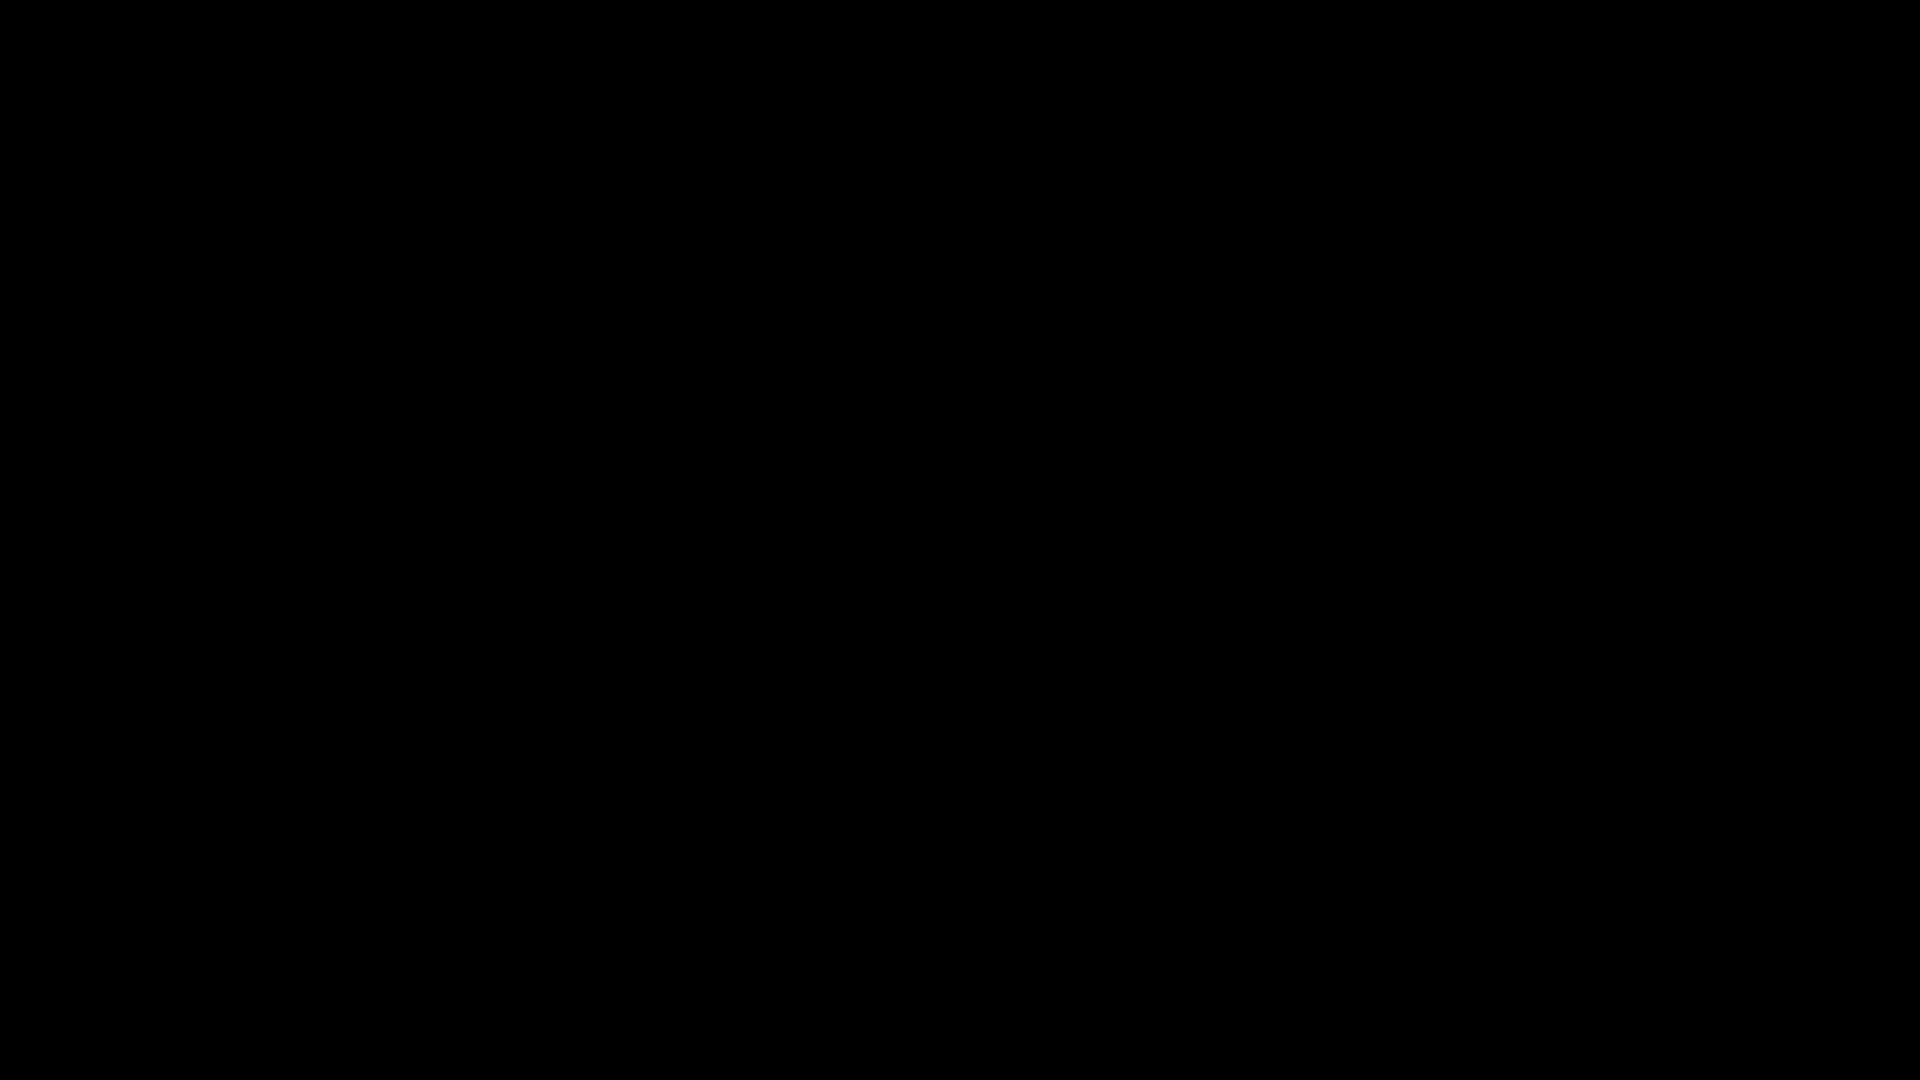
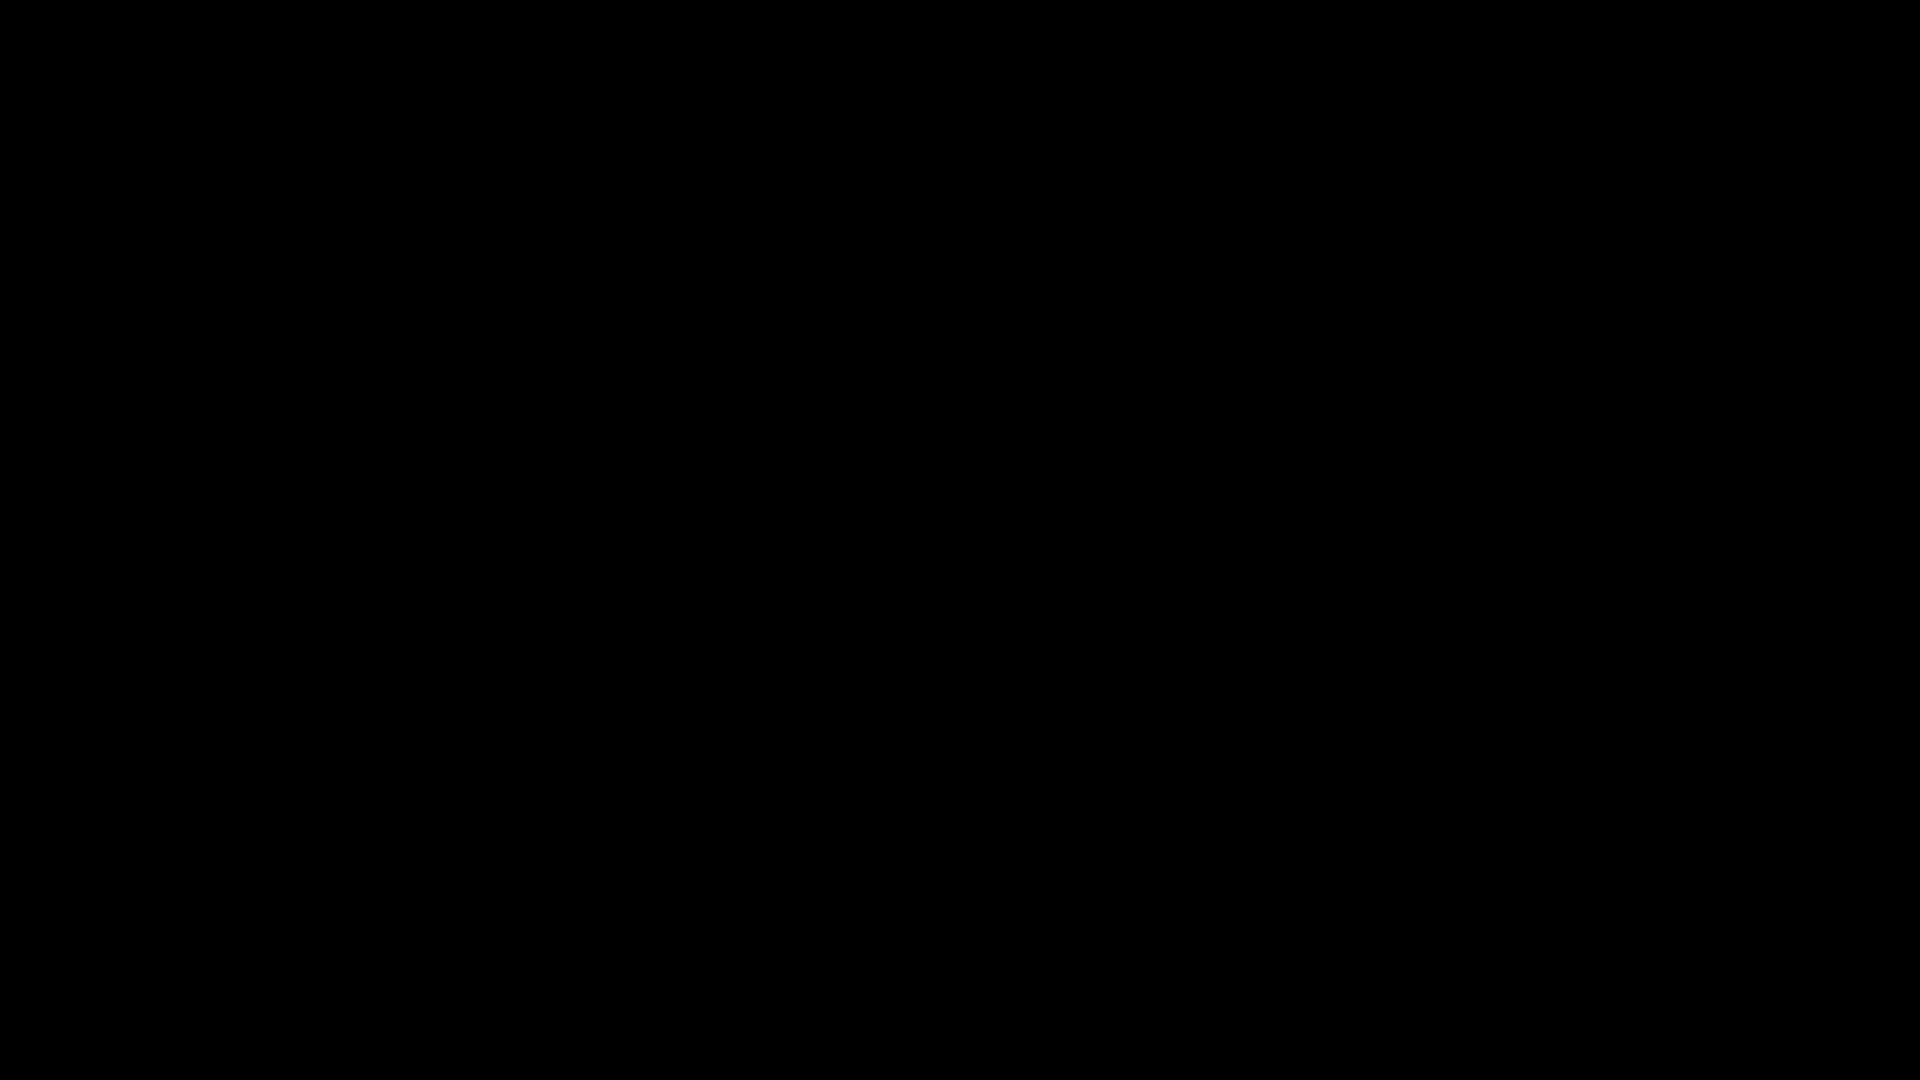

In [9]:
video_table.show()

In [10]:
video_table.add_column(audio_meta=get_metadata(video_table.audio))

Computing cells:   0%|                                                    | 0/2 [00:00<?, ? cells/s]

Computing cells: 100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 570.30 cells/s]


Added 2 column values with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio,audio_meta
,,"{'size': 8266796, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 7290936576, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 516.648}], 'bit_rate': 128006, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"
,,"{'size': 9245228, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 8153913600, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 577.8}], 'bit_rate': 128005, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"

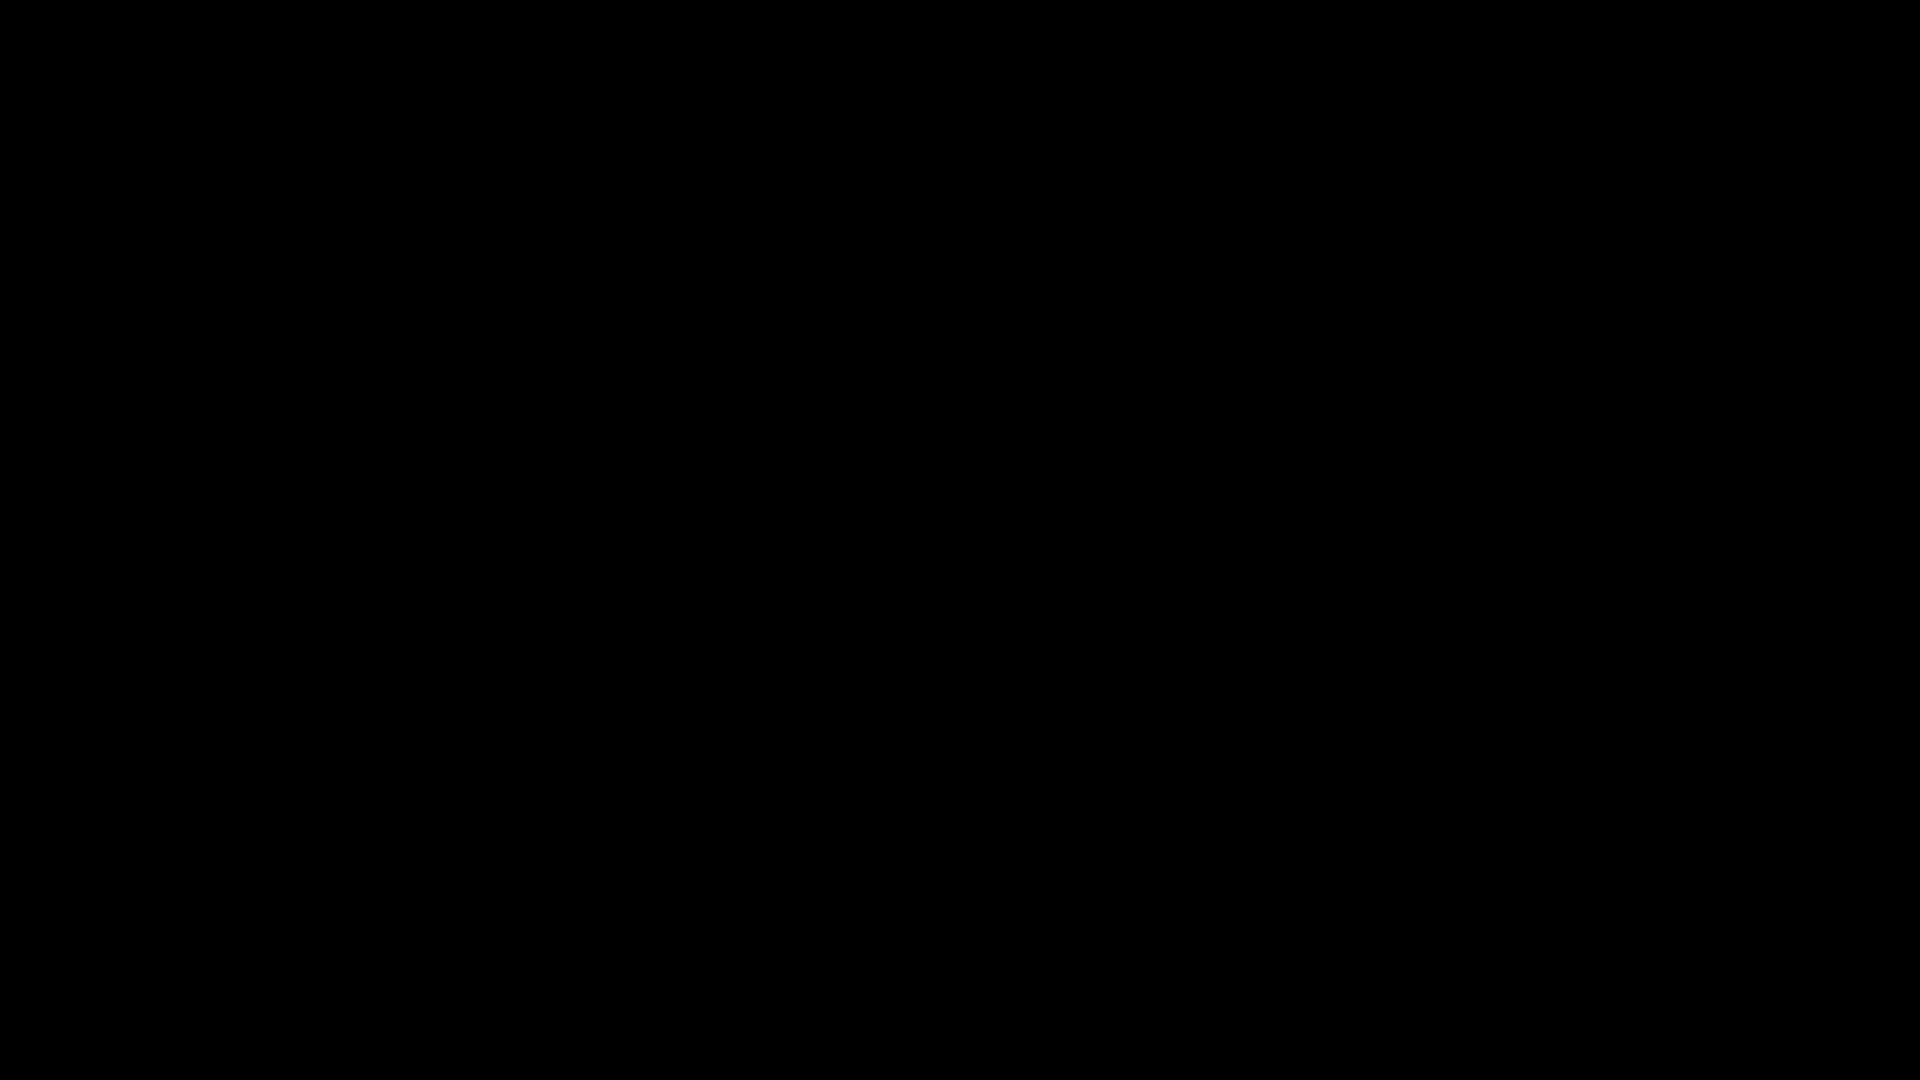
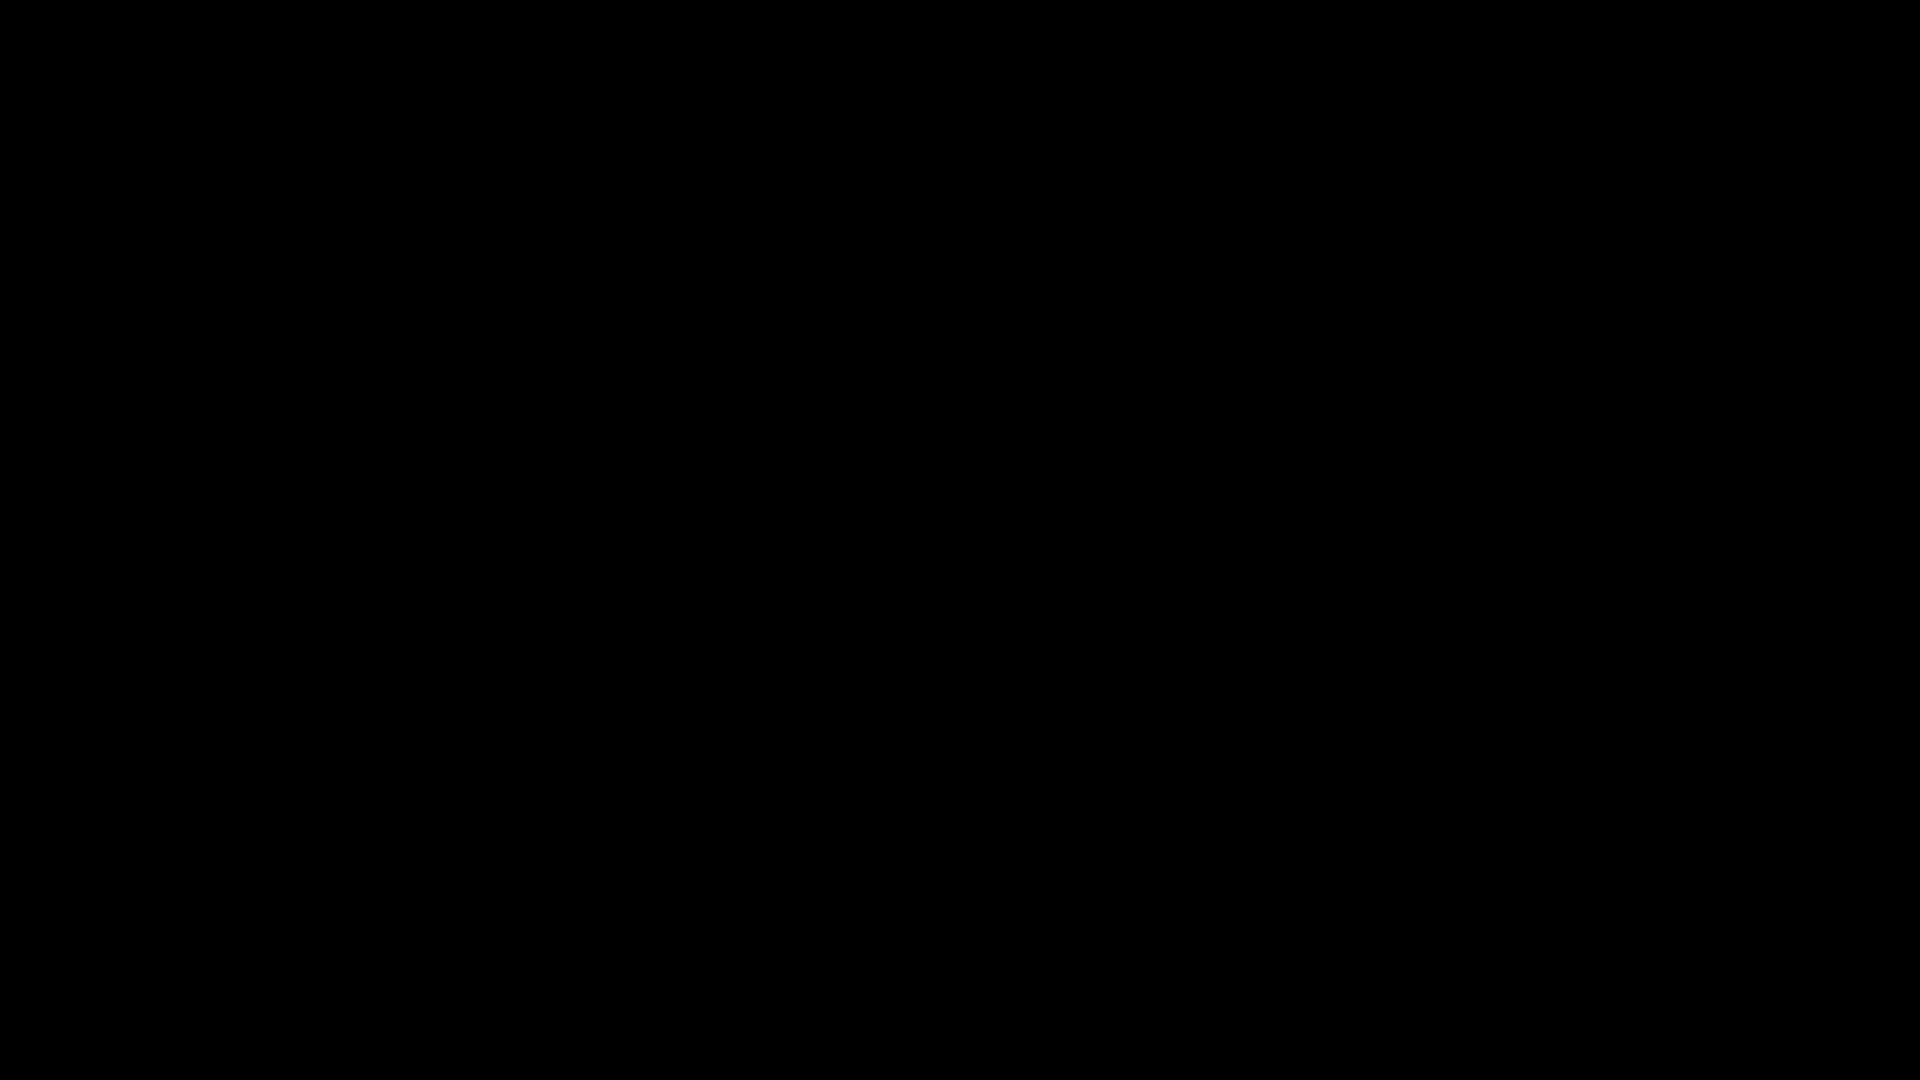

In [11]:
video_table.show()

In [12]:
video_table.add_column(transcription=openai.transcriptions(audio=video_table.audio, model='whisper-1'))

Computing cells:   0%|                                                    | 0/2 [00:00<?, ? cells/s]

Computing cells: 100%|████████████████████████████████████████████| 2/2 [00:54<00:00, 27.11s/ cells]


Added 2 column values with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

video  \
0  /Users/orm/repos/pixeltable/docs/drafts/whispe...   
1  /Users/orm/repos/pixeltable/docs/drafts/whispe...   

                                               audio  \
0  /Users/orm/.pixeltable/media/fab6e69bcb6b4a038...   
1  /Users/orm/.pixeltable/media/fab6e69bcb6b4a038...   

                                          audio_meta  \
0  {'size': 8266796, 'streams': [{'type': 'audio'...   
1  {'size': 9245228, 'streams': [{'type': 'audio'...   

                                       transcription  
0  {'text': 'The Snowflake back on track after a ...  
1  {'text': 'My mission is simple. To make you mo...
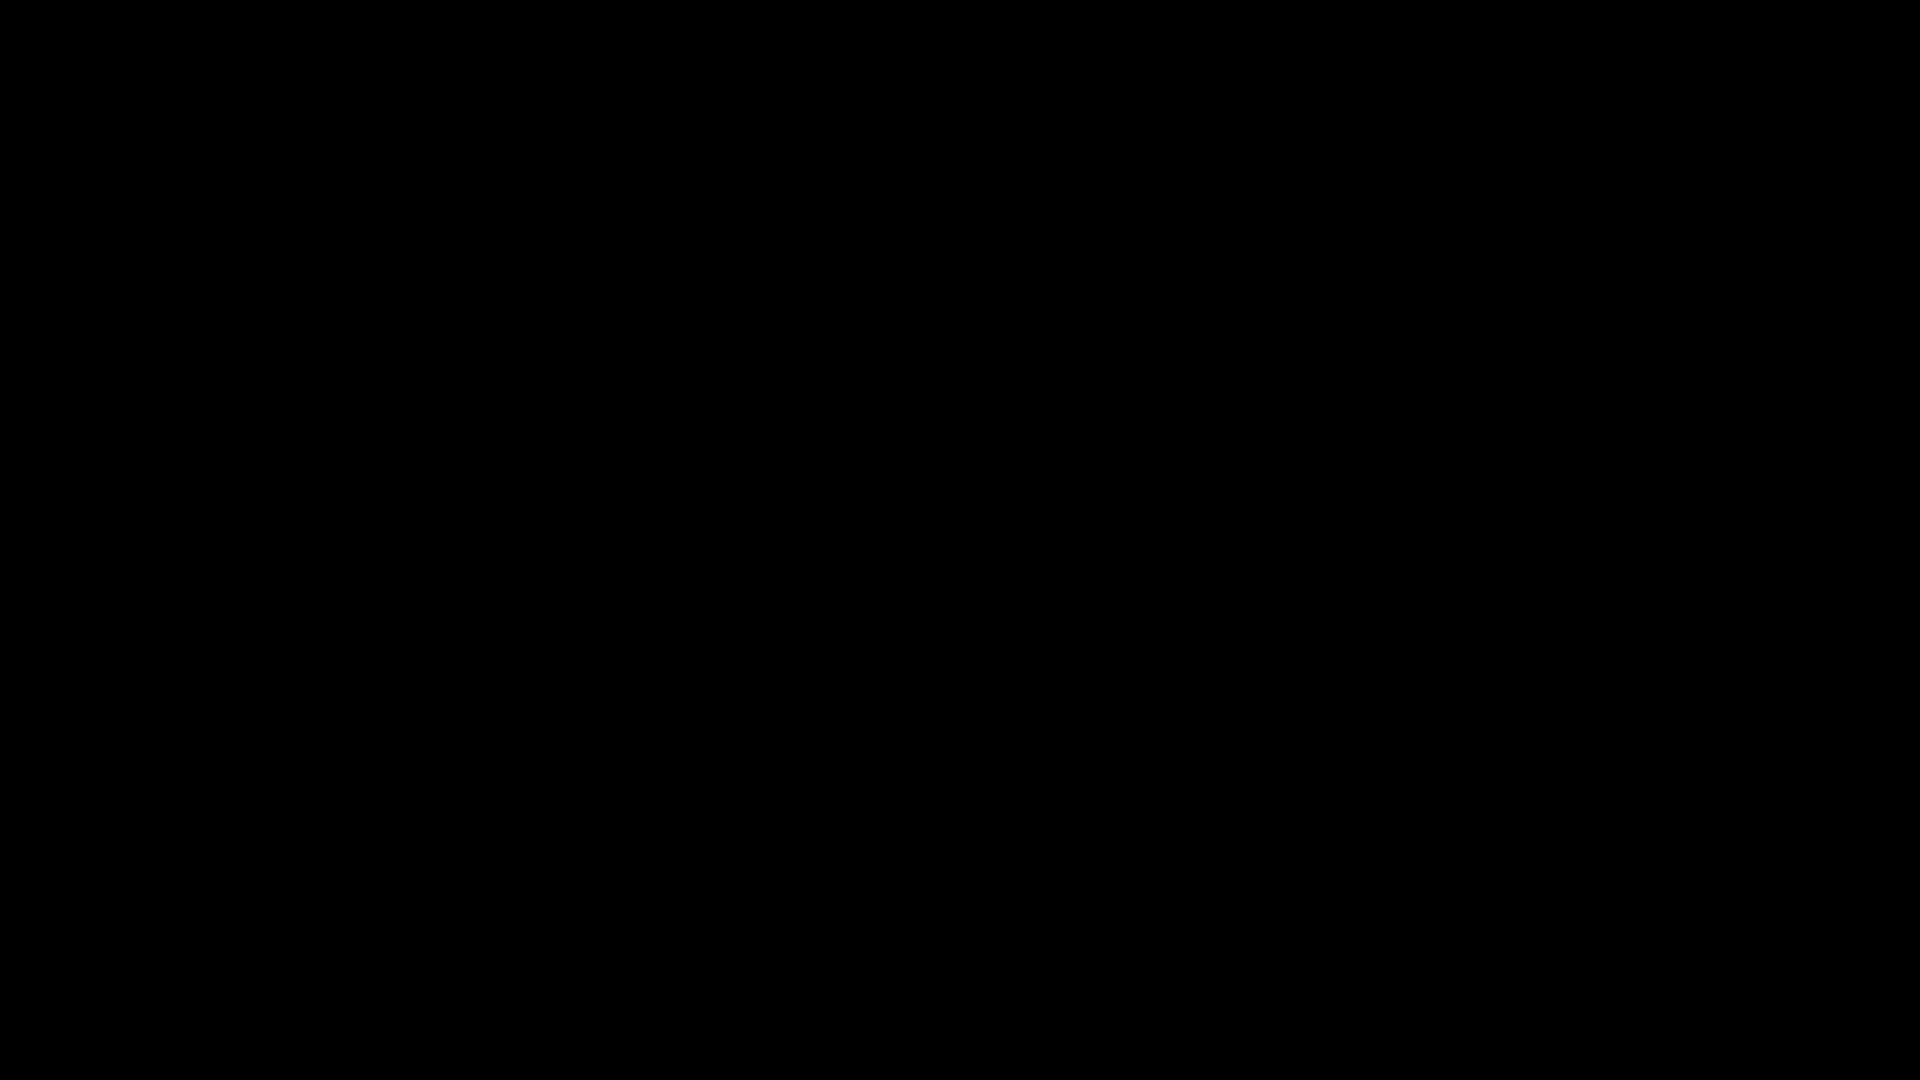
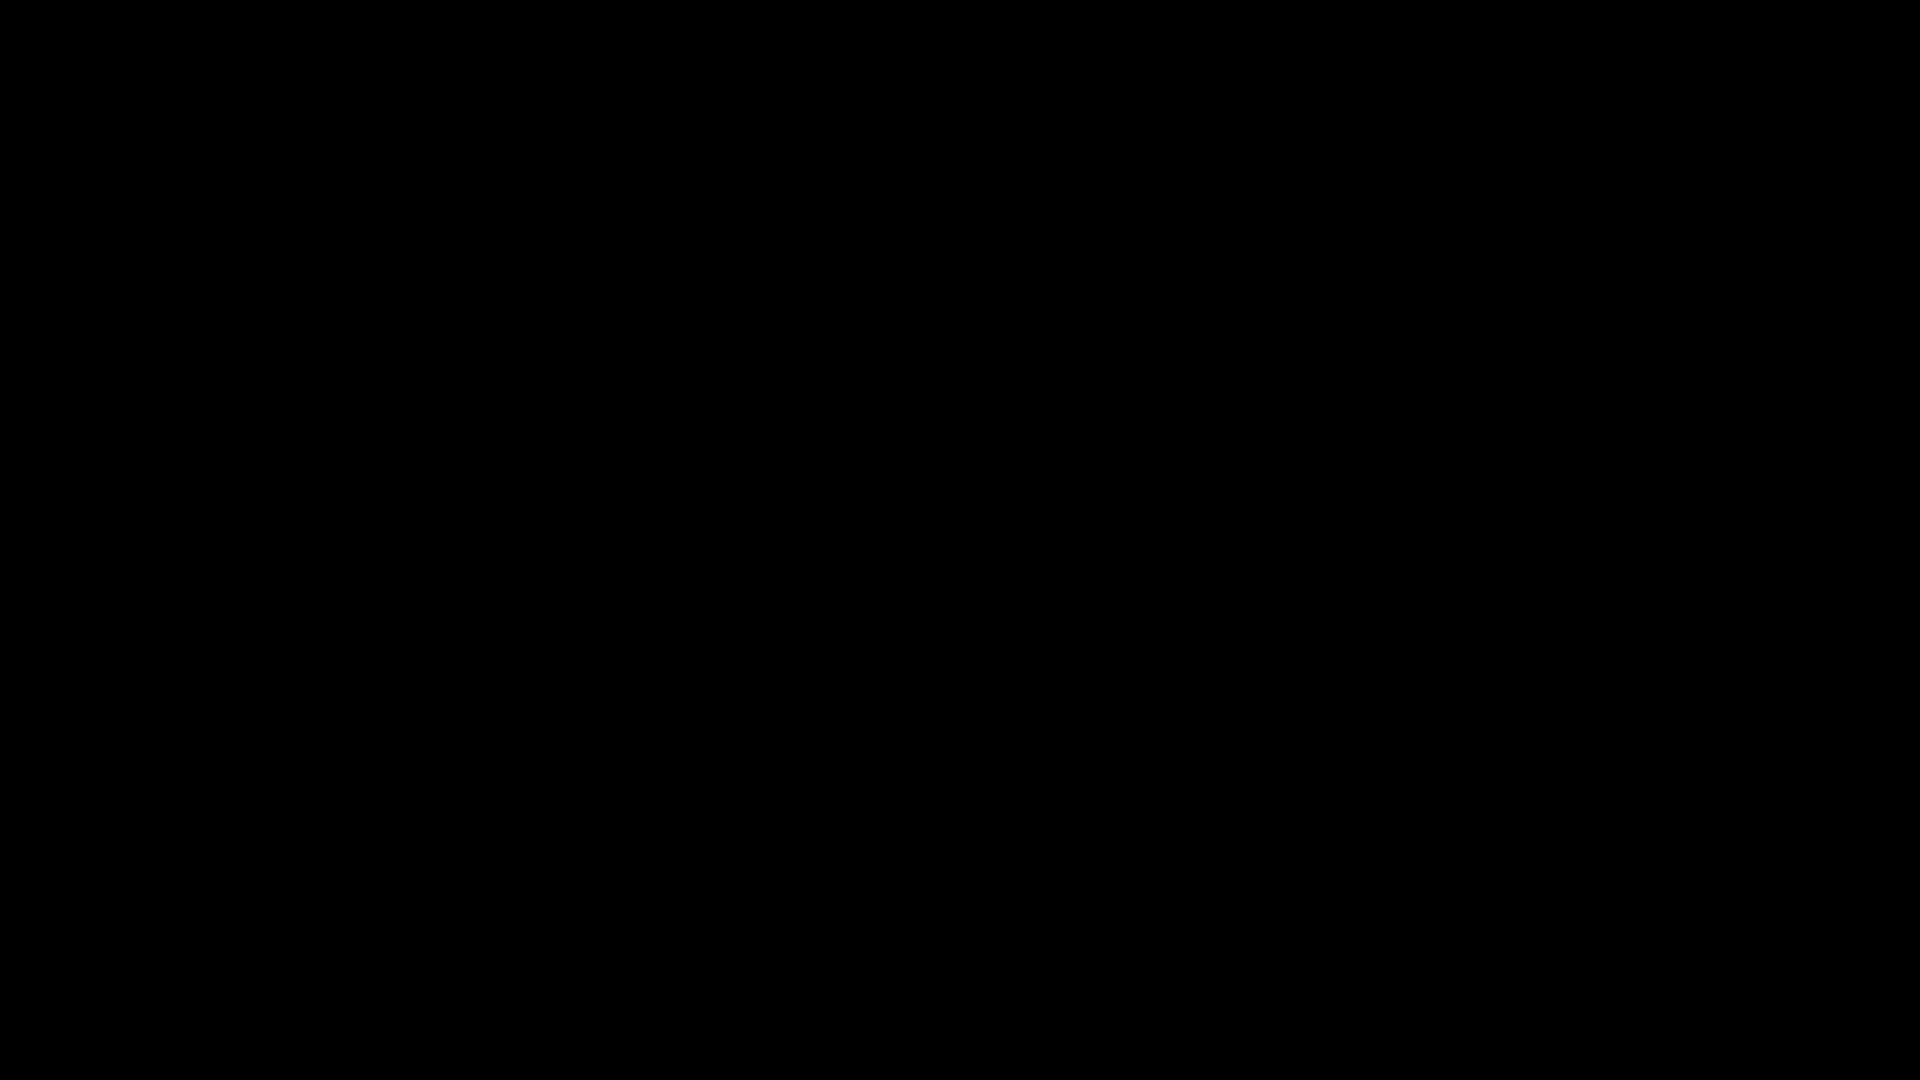

In [13]:
video_table.show()

In [14]:
@pxt.udf
def get_text(transcription: dict) -> str:
    return transcription['text']
video_table.add_column(transcription_text=get_text(video_table.transcription))

Computing cells:   0%|                                                    | 0/2 [00:00<?, ? cells/s]

Computing cells: 100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 720.24 cells/s]


Added 2 column values with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

In [15]:
from embeddings import SentenceSplitter, e5_embed

In [16]:
sentence_view = pxt.create_view('transcription_demo.sentence_view', video_table, iterator=SentenceSplitter.create(text=video_table.transcription_text))

Inserting rows into `sentence_view`: 0 rows [00:00, ? rows/s]

Inserting rows into `sentence_view`: 320 rows [00:00, 24655.61 rows/s]


Created view `sentence_view` with 320 rows, 0 exceptions.


In [17]:
sentence_view.select(sentence_view.pos, sentence_view.text).where(sentence_view.pos <= 10).show()

pos,text
0,The Snowflake back on track after a couple of months in the wilderness.
1,The last time we heard from this enterprise software data analytics companies back in February they put a strong quarter with a tepid four year forecast stock plunge from two hundred thirty down to the mid 100s.
2,Since then while many other tech names have rebounded like crazy stuff is only traded back up to 163 as of today's close.
3,But tonight these guys report tremendous core stuff like big expectations on every key line item for the quarter revenue product revenue operating income free cash flow.
4,You name it.
5,Take time as we gave a strong product revenue guidance for the current quarter and raise their full year product revenue forecast.
6,They gave you a little less a lower margin number but we'll find out about that.
7,So with the stock coming into the quarter cold these numbers were enough to send it higher.
8,And if you are just the beginning let's check in with Sridhar Ramaswamy.
9,He is the new CEO of Snowflake.


In [18]:
sentence_view.add_embedding_index(col_name='text', text_embed=e5_embed)

Computing cells:   0%|                                                  | 0/320 [00:00<?, ? cells/s]

Computing cells: 100%|████████████████████████████████████████| 320/320 [00:05<00:00, 61.07 cells/s]

In [19]:
sentence_view.select(sentence_view.text, sentence_view.text.similarity('you should buy NVIDIA')).order_by(sentence_view.text.similarity('you should buy NVIDIA'), asc=False).limit(20).collect()

text,col_1
Nvidia.,0.874378
Remember I remember when I was the only guy thinking about NVIDIA.,0.840364
To make you money.,0.835868
They're like hey have you seen NVIDIA today.,0.833230
You always have to follow the money when you're picking stocks.,0.826322
They're spending millions of spending just billions actually on building that are filled with yes Nvidia chips.,0.822200
You still want to make sure that the applications working well or you want to try out a new model.,0.817813
Our foundation model Arctic was unsurprisingly done on top of Nvidia chips.,0.814672
Sometimes you have to ask yourself where is the money going.,0.813343
Follow at Jim Cramer on X. Have a question.,0.812509


In [20]:
video_table.insert([{'video': video_path} for video_path in paths[2:]])

Computing cells:   0%|                                                    | 0/4 [00:00<?, ? cells/s]

Inserting rows into `video_table`: 0 rows [00:00, ? rows/s]

Inserting rows into `video_table`: 1 rows [00:00, 145.33 rows/s]


Computing cells: 100%|████████████████████████████████████████████| 4/4 [00:43<00:00, 10.80s/ cells]

Inserting rows into `sentence_view`: 0 rows [00:00, ? rows/s]

Inserting rows into `sentence_view`: 240 rows [00:00, 592.37 rows/s]


Inserted 241 rows with 0 errors.


UpdateStatus(num_rows=241, num_computed_values=4, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio,audio_meta
,,"{'size': 8266796, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 7290936576, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 516.648}], 'bit_rate': 128006, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"
,,"{'size': 9245228, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 8153913600, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 577.8}], 'bit_rate': 128005, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"
,,"{'size': 10607276, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 9355239936, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 662.928}], 'bit_rate': 128005, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"

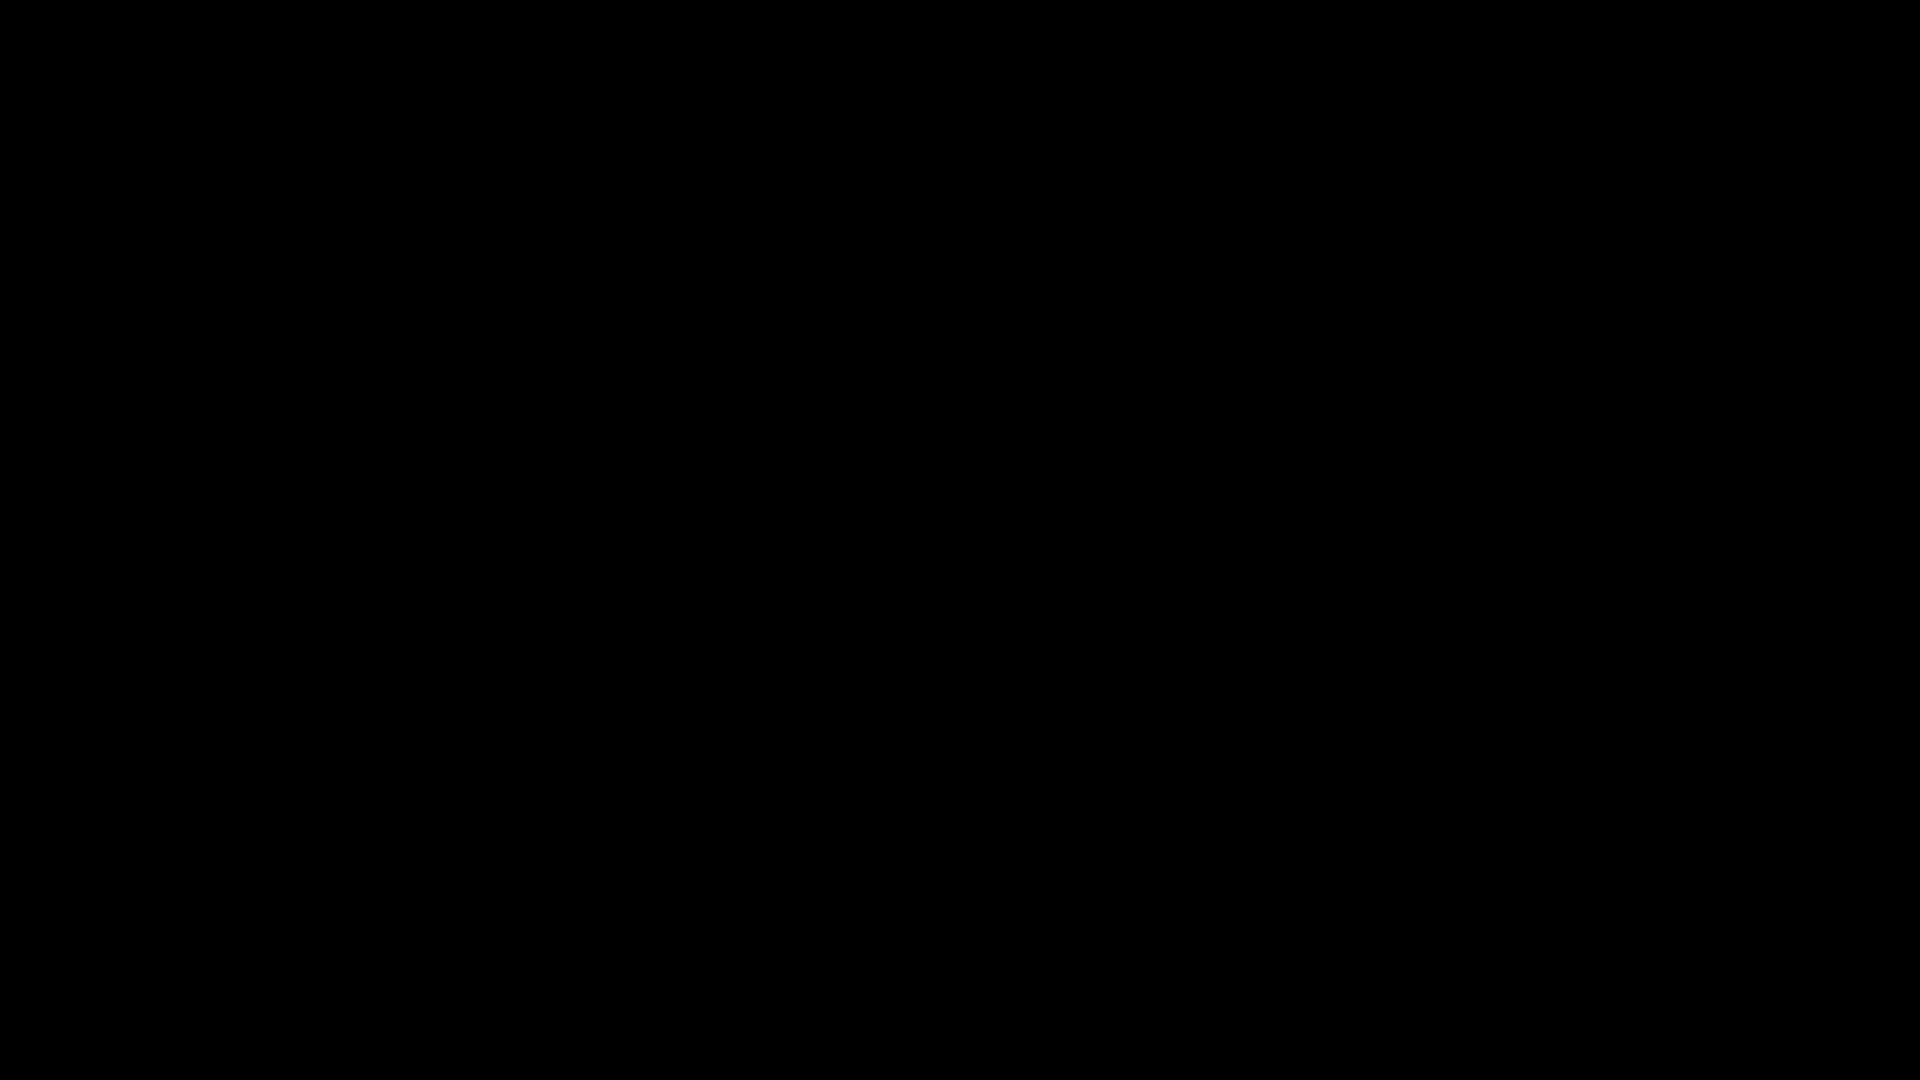
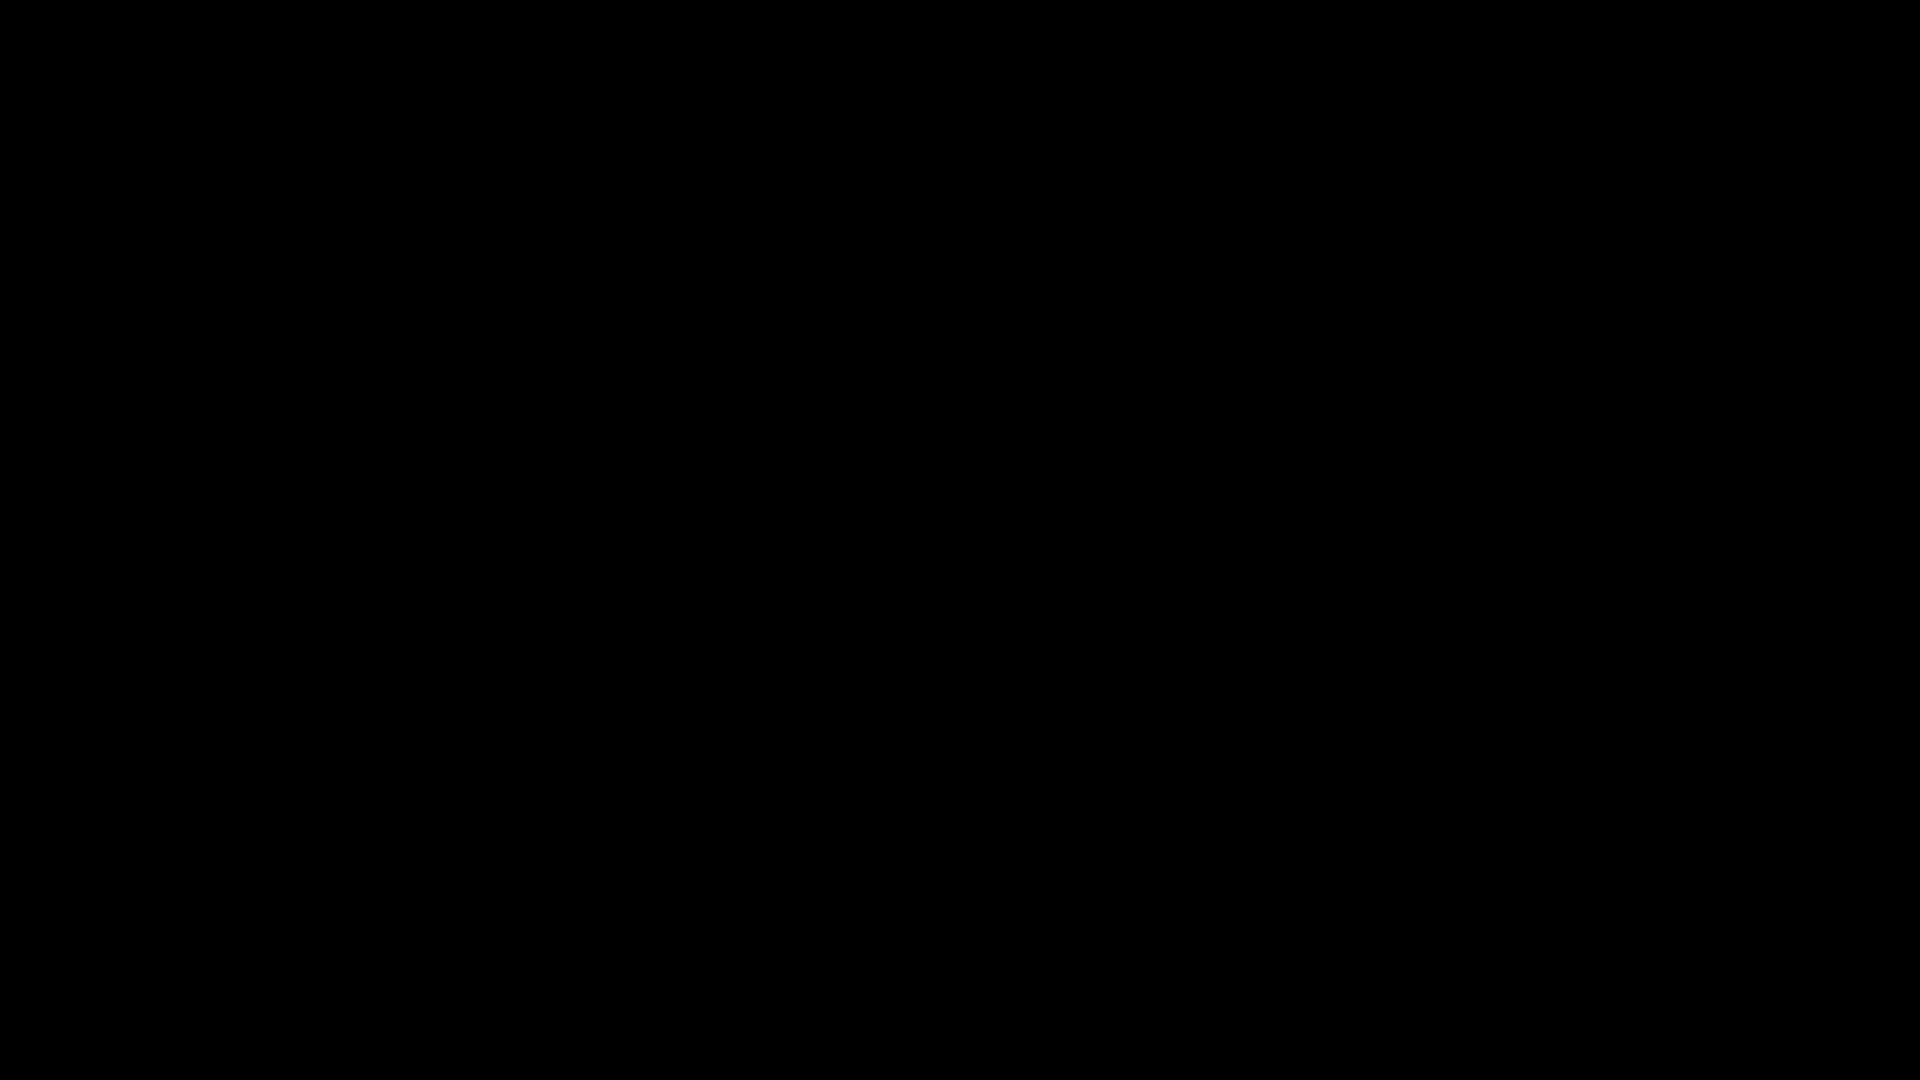
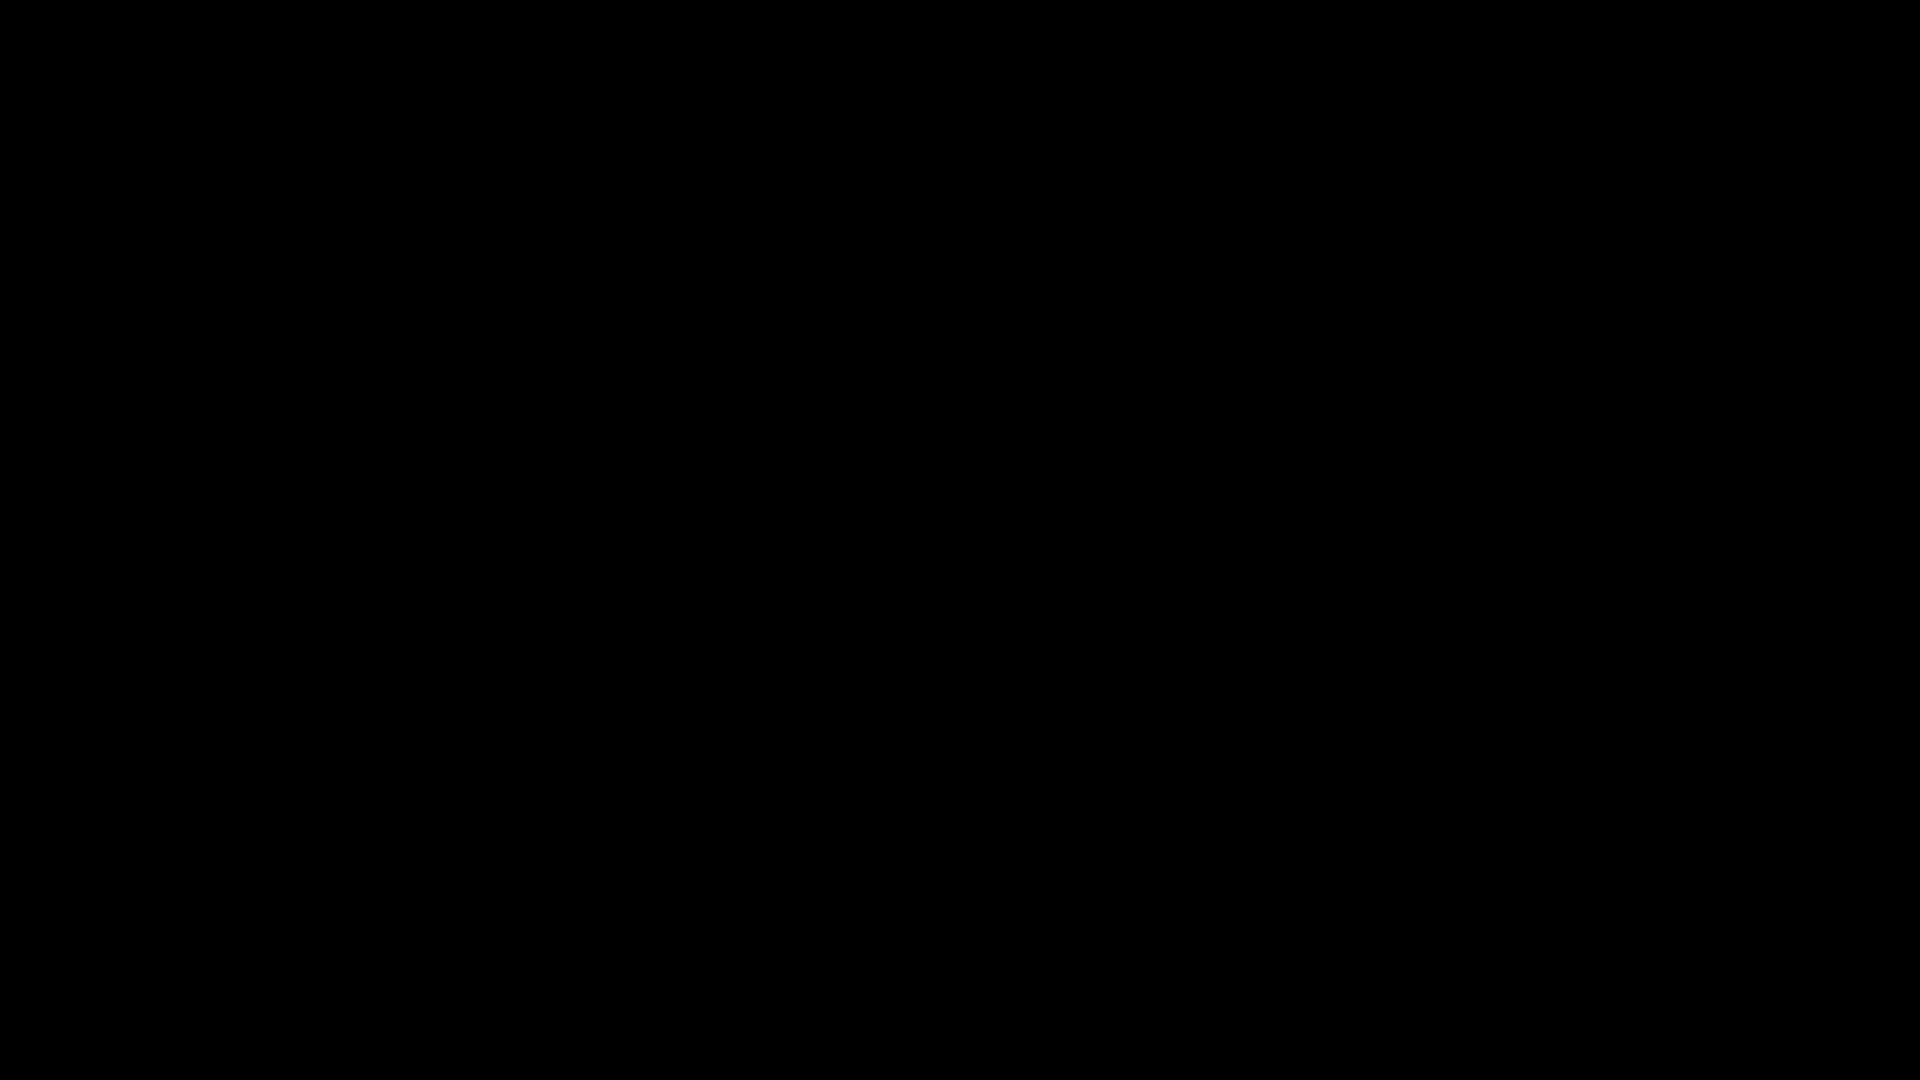

In [21]:
video_table.select(video_table.video, video_table.audio, video_table.audio_meta).show()